# Fluid Flow Example

Consider the nonlinear mean-field model of fluid flow past a circular cylinder at Reynolds number 100, described by empirical Galerkin model:
$$
\frac{\partial x_{1}}{\partial t} = \mu x_{1} - \omega x_{2} + A x_{1}x_{3}
$$
$$
\frac{\partial x_{2}}{\partial t} = \omega x_{1} + \mu x_{2} + Ax_{2}x_{3}
$$
$$
\frac{\partial x_{3}}{\partial t} = -\lambda(x_{3} - {x_{1}}^{2} - {x_{2}}^{2}) 
$$


Where $\mu = 0.1, \omega = 1, A=-0.1, \lambda = 10$

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from dmd_machine.dmd_ae_machine import DMDMachine
from dmd_machine.loss_function import LossFunction
from data.Data import DataMaker
from datetime import date 
from tensorflow.keras.models import model_from_json
from return_stats import *
from create_plots import *
from datetime import date  
import numpy.matlib
import pickle
import time
from pydmd import DMD
plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['figure.facecolor'] = 'white'
%matplotlib inline

In [3]:
training_data = pickle.load(open('./data/dataset_fluid.pkl', 'rb'))
data = training_data.data_val

In [4]:
data.shape

(10000, 3, 121)

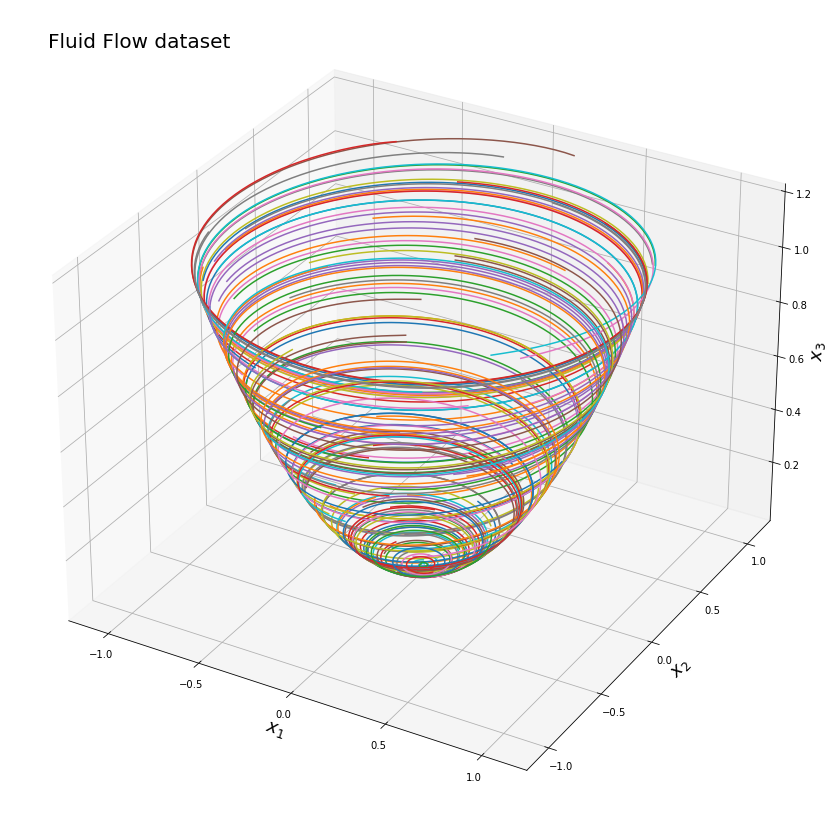

In [5]:
fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection='3d')

for ii in np.arange(0, 1e4, 105):
    ii = int(ii)
    x1 = data[ii, 0, :]
    x2 = data[ii, 1, :]
    x3 = data[ii, 2, :]
    ax.plot3D(x1, x2, x3)

ax.set_xlabel("$x_{1}$", fontsize=18)
ax.set_ylabel("$x_{2}$", fontsize=18)
ax.set_zlabel("$x_{3}$", fontsize=18)
ax.text2D(0.05, 0.95, "Fluid Flow dataset", transform=ax.transAxes, fontsize=20)
plt.savefig('figures/fluid_flow.png')


#ax.view_init(10, 10)
plt.show()


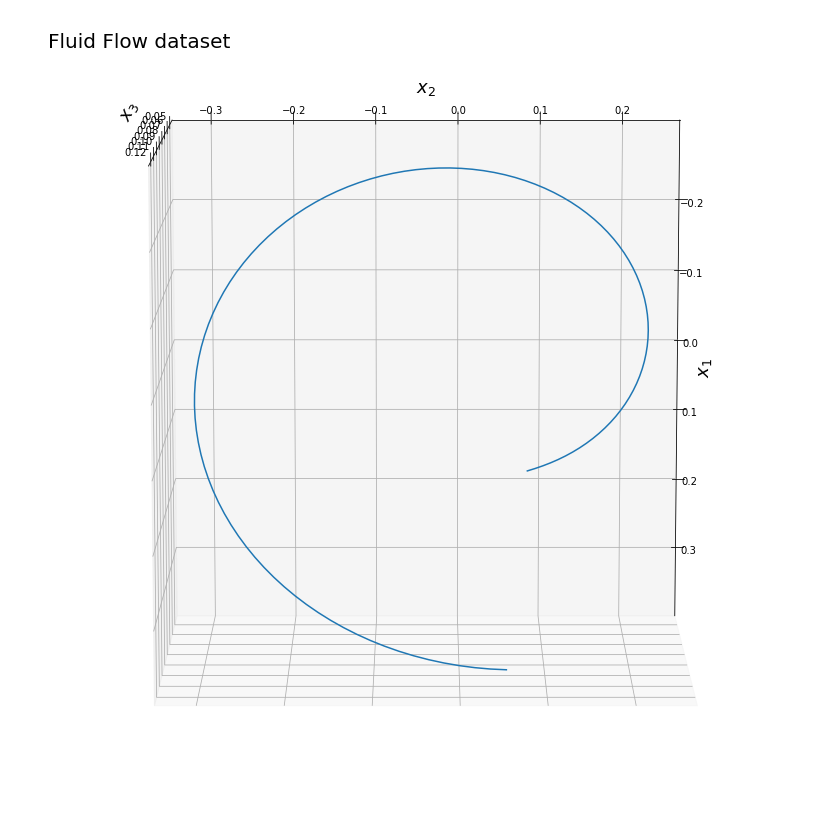

In [6]:
fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection='3d')


ii = 0
x1 = data[ii, 0, :]
x2 = data[ii, 1, :]
x3 = data[ii, 2, :]
ax.plot3D(x1, x2, x3)

ax.set_xlabel("$x_{1}$", fontsize=18)
ax.set_ylabel("$x_{2}$", fontsize=18)
ax.set_zlabel("$x_{3}$", fontsize=18)
ax.text2D(0.05, 0.95, "Fluid Flow dataset", transform=ax.transAxes, fontsize=20)
plt.savefig('figures/fluid_flow_overview.png')


ax.view_init(100, 0)
plt.show()


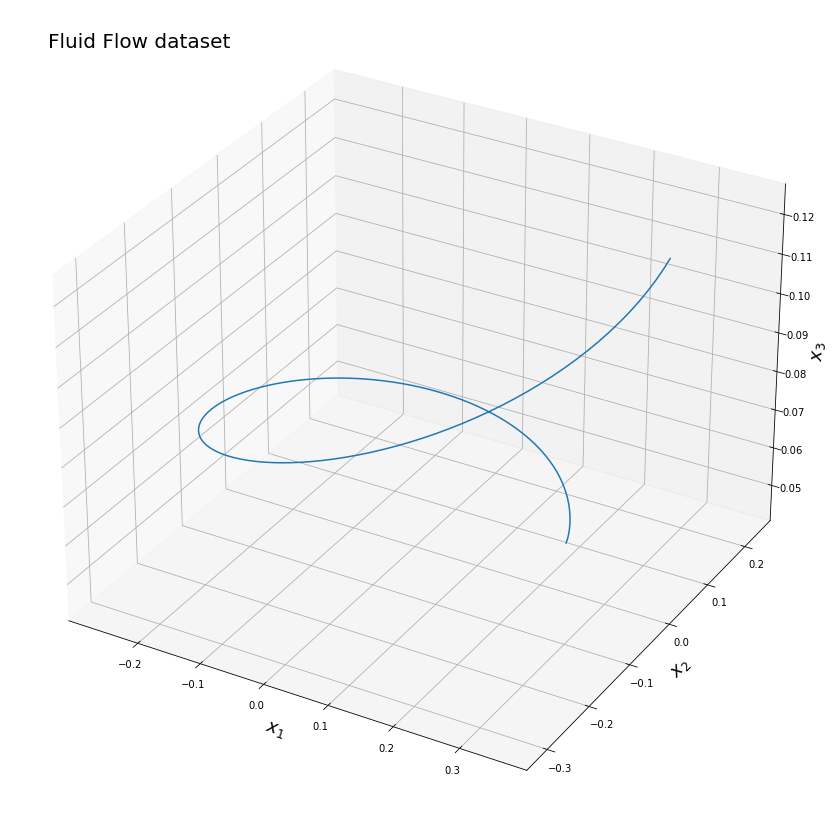

In [7]:
fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection='3d')


ii =0 
x1 = data[ii, 0, :]
x2 = data[ii, 1, :]
x3 = data[ii, 2, :]
ax.plot3D(x1, x2, x3)

ax.set_xlabel("$x_{1}$", fontsize=18)
ax.set_ylabel("$x_{2}$", fontsize=18)
ax.set_zlabel("$x_{3}$", fontsize=18)
ax.text2D(0.05, 0.95, "Fluid Flow dataset", transform=ax.transAxes, fontsize=20)
plt.savefig('figures/fluid_flow_sideview.png')


plt.show()

# Evaluate DMD Loss. 


$DMD_{loss}=\arg \min _{A}\left\| {X}^{+}- A\cdot X^{-} \right\| _{F}^{2}$

$ X^{+} = A \cdot X^{-}$

By the singular value decomposition, 

$ X^{-} = U \cdot \Sigma \cdot V^{T}$

Then, 

$ A = X^{+} \cdot V \cdot \Sigma^{-1} \cdot U^{*}$,

Hence, 

$ \left\| {X}^{+}- A\cdot X^{-} \right\| _{F}^{2} = 
\left\| {X}^{+}- (X^{+} \cdot V \cdot \Sigma^{-1} \cdot U^{*})\cdot X^{-} \right\| _{F}^{2} =
\left\| {X}^{+}- (X^{+} \cdot V \cdot \Sigma^{-1} \cdot U^{*})\cdot ( U \cdot \Sigma \cdot V^{T}) \right\| _{F}^{2} = 
\left\| {X}^{+}( I - V \cdot V^{T}) \right\| _{F}^{2}$

$ Loss_{dmd} = \left\| {X}^{+}( I - V \cdot V^{T}) \right\| _{F}^{2}$

In [8]:
def dmd_loss(x_data):
    x_minus = x_data[:, :-1]
    x_plus = x_data[:, 1:]

    U, S, Vt = np.linalg.svd(x_minus, full_matrices=True)

    I = np.identity(np.shape(Vt)[0])

    VVt = np.matmul(np.transpose(Vt), Vt)

    for_norm = np.linalg.norm(np.matmul(x_plus, (I - VVt)), ord='fro')
    
    return for_norm

In [9]:
for_vec_x = np.zeros(np.shape(training_data.data_val)[0])

In [10]:
for ii in range(0, np.shape(training_data.data_val)[0]):
    loss = dmd_loss(data[ii, :, :])
    for_vec_x[ii] = loss

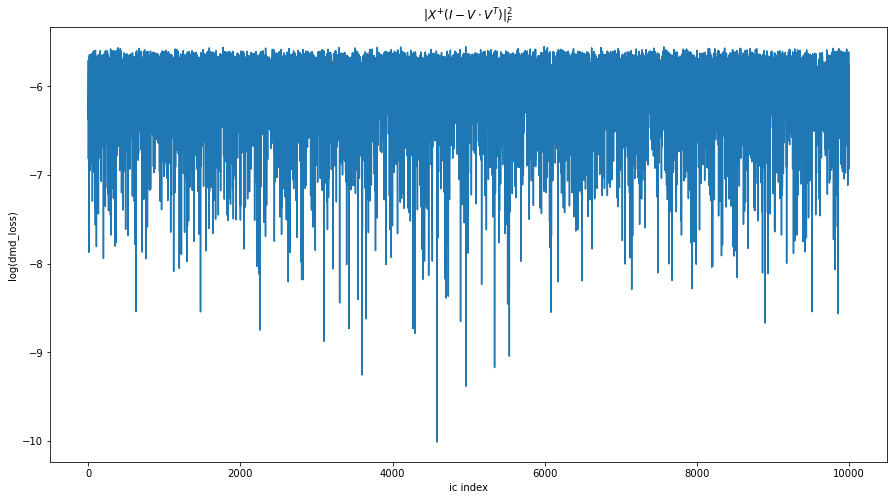

In [11]:
_ = plt.figure(figsize=(15,8))
_ = plt.plot(np.log10(for_vec_x))
_ = plt.ylabel("log(dmd_loss)")
_ = plt.xlabel("ic index")
_ = plt.title("$\| {X}^{+}( I - V \cdot V^{T})\| _{F}^{2}$")

# Apply DMD Algorithm

In [12]:
def dmd_fit(x_mat):
    # Perform DMD method
    x_minus = x_mat[:, :-1]
    x_plus = x_mat[:, 1:]

    # singular value decomposition.
    u, s, vh = np.linalg.svd(x_minus, full_matrices=False)
    u, vh = np.matrix(u), np.matrix(vh)

    # compute Atilde.
    Atilde = u.H @ x_plus @ vh.H @ np.diag(1. / s)

    # compute the eigenvalues and eigenvectors of Atilde.
    eigs, eig_vecs = np.linalg.eig(Atilde)

    # find b.
    b = np.linalg.solve(eig_vecs, x_mat[:, 0])

    # reconstruct dmd.
    dmd_rec = np.zeros((x_mat.shape[0], x_mat.shape[1]), dtype = "complex_")
    
    dmd_rec[:, 0] = x_mat[:, 0]
    
    power_lam = np.diag(np.ones(len(eigs)))
                        
    for ii in range(1, x_mat.shape[1]):
        dmd_rec[:, ii] = eig_vecs @ power_lam @ b
        power_lam = power_lam @ np.diag(eigs)
        #dmd_rec[:, ii] = (Atilde**ii) @ x_mat[:, 0]
    return [eigs, eig_vecs, b, dmd_rec]

In [13]:
def dmd_cmp(Gtot, thrshld):
    mrow, ncol = Gtot.shape
    Ga = np.matlib.repmat((np.mean(Gtot, 1)).reshape(mrow, 1), 1, ncol)
    gfluc = Gtot - Ga
    gm = gfluc[:, :-1]
    gp = gfluc[:, 1:]
    u, s, vh = np.linalg.svd(gm, full_matrices=False)
    sm = np.max(s)
    indskp = np.log10(s/sm) > -thrshld
    print("# of singular values = ", indskp)
    sr = s[indskp]
    print(sr)
    ur = u[:, indskp]
    v = np.conj(vh.T)
    vr = v[:, indskp]
    
    kmat = gp @ vr @ np.diag(1./ sr) @ np.conj(ur.T)
    
    evls, evcs = np.linalg.eig(kmat)
    phim = (np.linalg.solve(evcs, gm)).T
    
    return evls, phim, evcs, Ga
    

In [14]:
def recon(phim, evls, evcs, ga):
    b = phim[:, 0]
    rec = np.zeros((phim.shape))
    mags = b
    for i in range(phim.shape[1]):
        rec[:, i] = np.dot(evcs, mags)
        mags = mags*evls
    rec += ga[:, :-1]
    return rec

In [15]:
window_size = 50
random_batch = data[:window_size, :, :]

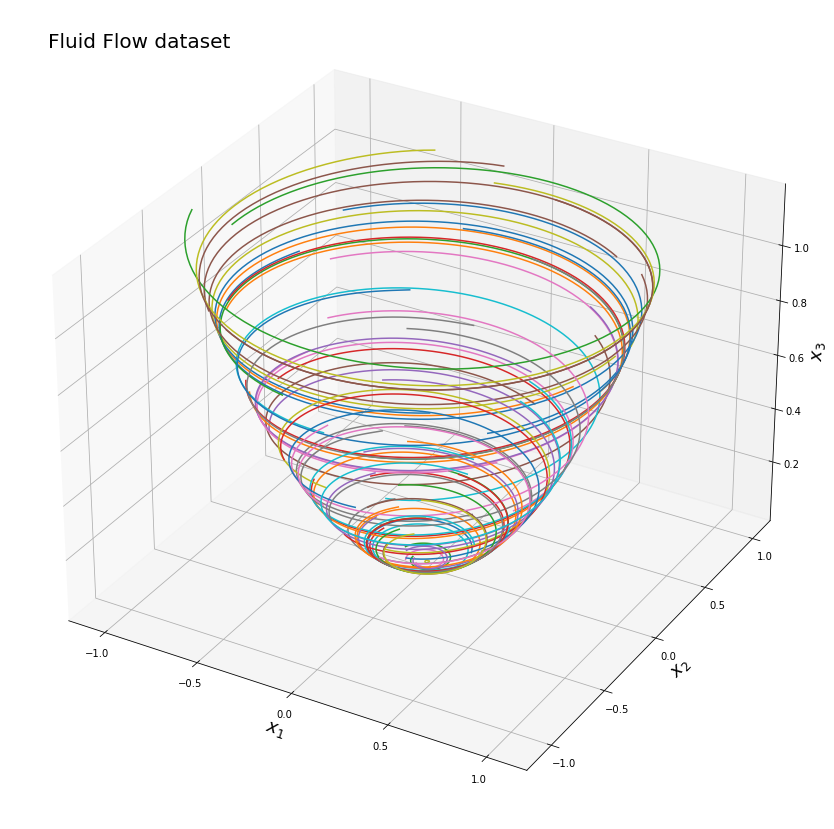

In [16]:
fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection='3d')

for ii in np.arange(0, random_batch.shape[0]):
    x1 = random_batch[ii, 0, :]
    x2 = random_batch[ii, 1, :]
    x3 = random_batch[ii, 2, :]
    ax.plot3D(x1, x2, x3)

ax.set_xlabel("$x_{1}$", fontsize=18)
ax.set_ylabel("$x_{2}$", fontsize=18)
ax.set_zlabel("$x_{3}$", fontsize=18)
ax.text2D(0.05, 0.95, "Fluid Flow dataset", transform=ax.transAxes, fontsize=20)

plt.show()

In [17]:
# reshape the matrix to be 15 x timesteps 
reshape_mat = np.zeros((3*window_size, random_batch.shape[-1]))

for ii in range(window_size):
    reshape_mat[3* ii, :] = random_batch[ii, 0, :]
    reshape_mat[3* ii + 1, :] = random_batch[ii, 1, :]
    reshape_mat[3* ii + 2, :] = random_batch[ii, 2, :]

In [18]:
reshape_mat.shape

(150, 121)

In [56]:
# pydmd fit 
dmd = DMD(svd_rank=4)
dmd.fit(reshape_mat)
dmd_rec = dmd.reconstructed_data.real

C:\Users\Opali\AppData\Local\Continuum\anaconda3\envs\tf\lib\site-packages\pydmd\dmdbase.py:215: UserWarning: Input data matrix X has condition number 9223460407.718536. Consider preprocessing data, passing in augmented data matrix, or regularization methods.
  .format(cond_number))


Eigenvalue (1.0001564107265413+0.05015739954599391j): distance from unit circle 0.001413306605526632
Eigenvalue (1.0001564107265413-0.05015739954599391j): distance from unit circle 0.001413306605526632
Eigenvalue (1.000763212824956+0.001626968759205346j): distance from unit circle 0.0007645353284015943
Eigenvalue (1.000763212824956-0.001626968759205346j): distance from unit circle 0.0007645353284015943


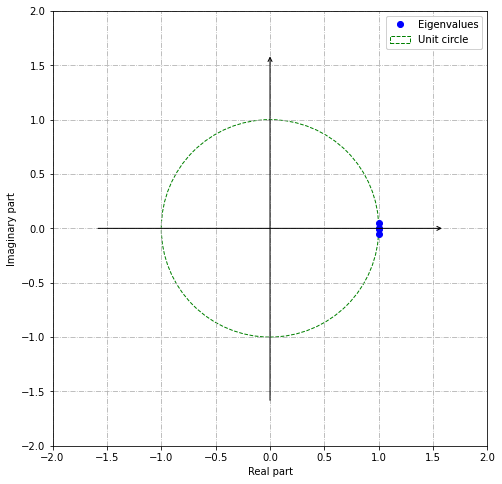

In [57]:
for eig in dmd.eigs:
    print('Eigenvalue {}: distance from unit circle {}'.format(eig, np.abs(np.sqrt(eig.imag**2+eig.real**2) - 1)))

dmd.plot_eigs(show_axes=True, show_unit_circle=True)

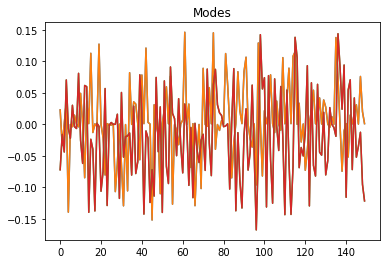

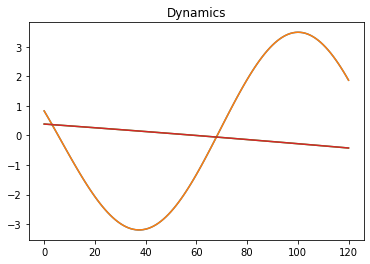

In [58]:
for mode in dmd.modes.T:
    plt.plot(mode.real)
    plt.title('Modes')
plt.show()

for dynamic in dmd.dynamics:
    plt.plot(dynamic.real)
    plt.title('Dynamics')
plt.show()

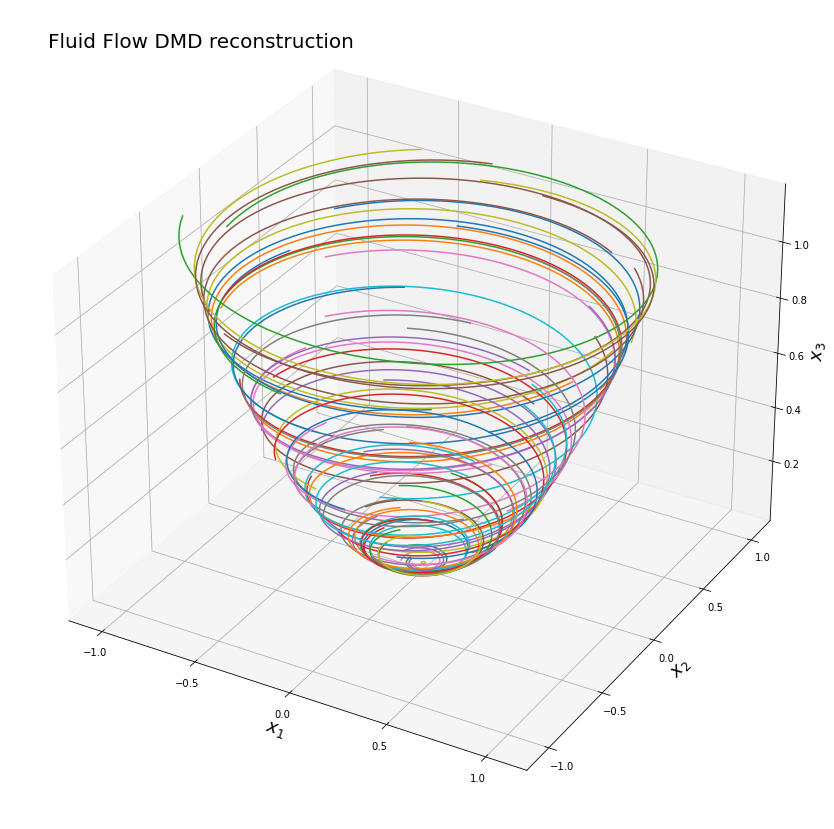

In [60]:
fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection='3d')

for ii in np.arange(0, random_batch.shape[0]):
    x1 = dmd_rec[3* ii, :]
    x2 = dmd_rec[3* ii + 1, :]
    x3 = dmd_rec[3* ii + 2, :]
    ax.plot3D(x1, x2, x3)

ax.set_xlabel("$x_{1}$", fontsize=18)
ax.set_ylabel("$x_{2}$", fontsize=18)
ax.set_zlabel("$x_{3}$", fontsize=18)
ax.text2D(0.05, 0.95, "Fluid Flow DMD reconstruction", transform=ax.transAxes, fontsize=20)

plt.show()

# Prediction Error

In [61]:
error_mat = reshape_mat - dmd_rec

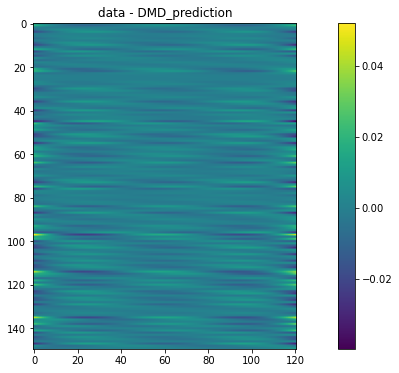

In [62]:
fig = plt.figure(figsize=(15, 6))
plt.imshow(error_mat)
plt.colorbar()
plt.title("data - DMD_prediction")
plt.show()

In [63]:
error_mat.mean()

-5.4930440548344245e-06

In [75]:
evls, phim, evcs, Ga = dmd_cmp(reshape_mat, 1.85)

# of singular values =  [ True  True  True  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]
[37.41514368 35.19608651  2.92500185  0.67339121]


In [76]:
dmd_res = recon(phim.T, evls, evcs, Ga).real

C:\Users\Opali\AppData\Local\Continuum\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


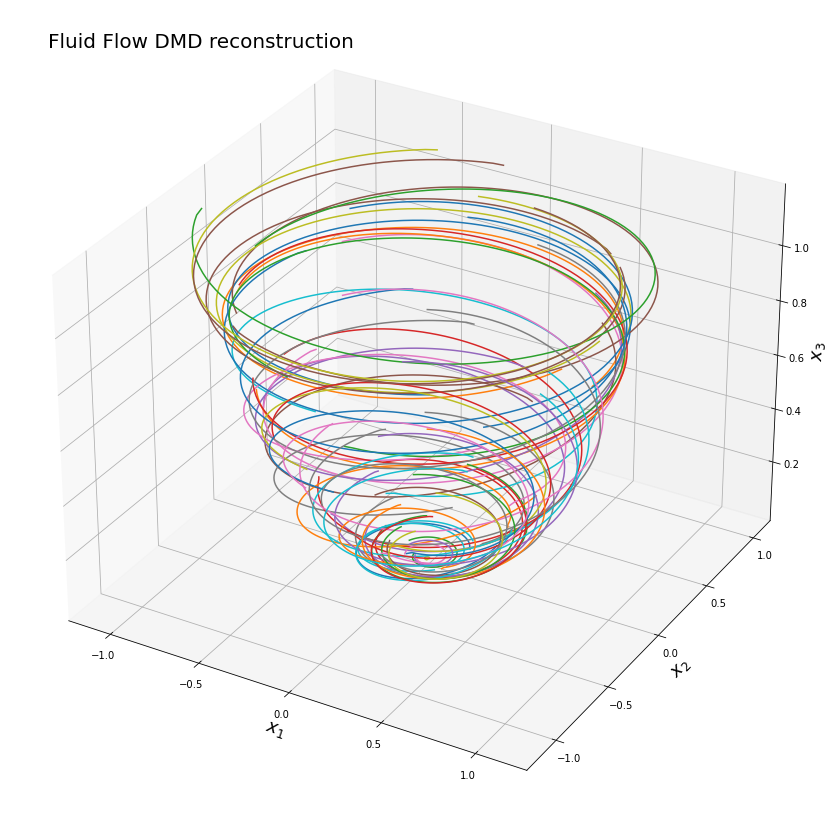

In [77]:
fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection='3d')

for ii in np.arange(0, random_batch.shape[0]):
    x1 = dmd_res[3* ii, :]
    x2 = dmd_res[3* ii + 1, :]
    x3 = dmd_res[3* ii + 2, :]
    ax.plot3D(x1, x2, x3)

ax.set_xlabel("$x_{1}$", fontsize=18)
ax.set_ylabel("$x_{2}$", fontsize=18)
ax.set_zlabel("$x_{3}$", fontsize=18)
ax.text2D(0.05, 0.95, "Fluid Flow DMD reconstruction", transform=ax.transAxes, fontsize=20)

plt.show()

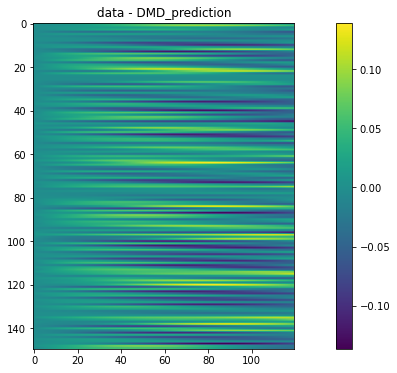

In [78]:
err = reshape_mat[:, :-1]- dmd_res
fig = plt.figure(figsize=(15, 6))
plt.imshow(err)
plt.colorbar()
plt.title("data - DMD_prediction")
plt.show()

In [79]:
err.mean()

0.0007139720735783681